# Exploratory Data Analysis
we are exploring the data, which is inside database to gain insights and uncover the underlying patterns.

>### Importing Libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

>### Connecting with **PostgreSQL** Data-Base

In [18]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "postgres"  # username
password = "tictok#2020"  # password
host = "localhost"  # server IP
port = "5432"  # port no
database = "financial_risk_analytics"  # Data-Base name

try:
    engine = create_engine(
        f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    )
    with engine.connect() as connection:
        print("Successfully connected to PostgreSQL Data-Base")

except Exception as exc:
    print("Error while connecting to PostgreSQL", exc)

Successfully connected to PostgreSQL Data-Base


>### Data Analysis Process

#### Q1: Which portfolios currently exceed their defined exposure limits, and by how much?

In [159]:
sql_query_q1 = """
WITH
    portfolio_exposure AS (
        SELECT
            prt.portfolio_name,
            SUM(pos.exposure_value) AS exposure_value,
            MAX(prt.exposure_limit) AS exposure_limit
        FROM
            positions pos
            JOIN portfolios prt ON prt.portfolio_id = pos.portfolio_id
        GROUP BY
            prt.portfolio_name
    )
SELECT
    portfolio_name,
    exposure_value,
    exposure_limit,
    (exposure_value - exposure_limit) AS breach_amount,
    CASE
        WHEN exposure_value > exposure_limit THEN 'Limit Exceeds'
        ELSE 'Within Limit'
    END AS breach_status
FROM
    portfolio_exposure
ORDER BY
    breach_amount DESC;
"""

df_bap = pd.read_sql(sql=sql_query_q1, con=engine)
df_bap.head()

,portfolio_name,exposure_value,exposure_limit,breach_amount,breach_status
0,Fund_025,76634711.48,57991978.20,18642733.28,Limit Exceeds
1,Fund_019,72638217.74,55241732.12,17396485.62,Limit Exceeds
2,Fund_048,76835168.87,65287754.41,11547414.46,Limit Exceeds
3,Fund_010,93737819.41,86720273.87,7017545.54,Limit Exceeds
4,Fund_004,81079737.66,74247067.20,6832670.46,Limit Exceeds


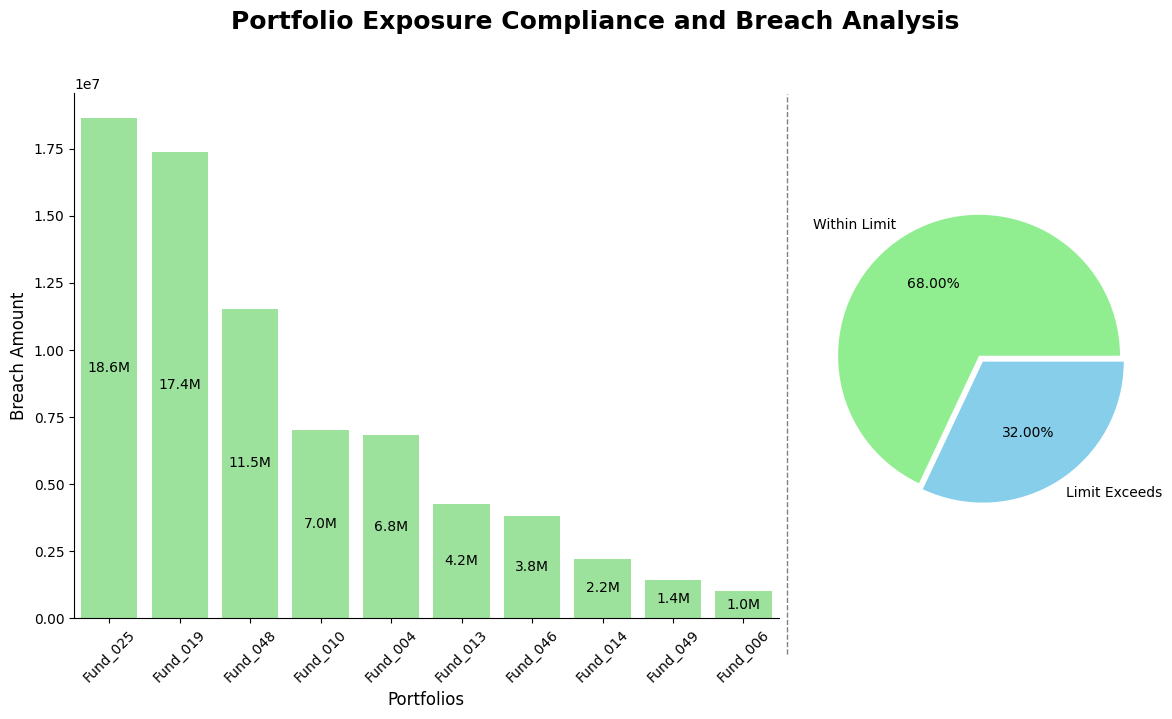

In [200]:
# Create combined figure with custom widths
fig, axes = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={"width_ratios": [2, 1]})

# --- Bar chart on the left ---
sns.barplot(
    data=df_bap.head(10),
    x="portfolio_name",
    y="breach_amount",
    color="lightgreen",
    ax=axes[0],  # <-- assign to left subplot
)
sns.despine(ax=axes[0], top=True, right=True)
axes[0].set_xlabel("Portfolios", fontsize=12)
axes[0].set_ylabel("Breach Amount", fontsize=12)
axes[0].tick_params(axis="x", rotation=45)

# Add labels on bars
for bar in axes[0].containers:
    values = [rect.get_height() for rect in bar]
    formatted_labels = [
        f"{value / 1000000:.1f}M" if value >= 1000000 else f"{value:.1f}"
        for value in values
    ]
    axes[0].bar_label(bar, labels=formatted_labels, label_type="center", fontsize=10)

# --- Pie chart on the right ---
sizes = df_bap["breach_status"].value_counts().values
labels = df_bap["breach_status"].value_counts().index
axes[1].pie(
    x=sizes,
    labels=labels,
    autopct="%.2f%%",
    colors=["lightgreen", "skyblue"],
    startangle=0,
    explode=(0, 0.05),  # optional: explode the 'Exceeded' slice
)

fig.suptitle(
    "Portfolio Exposure Compliance and Breach Analysis",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)

# --- Partition Line (Optional, clean visual separation) ---
fig.add_artist(
    plt.Line2D((0.66, 0.66), (0.1, 0.9), color="gray", linewidth=1, linestyle="--")
)

plt.tight_layout()
plt.show()

##### Insights :
1. **Overall Compliance:** Out of 50 portfolios, 16 portfolios (32%) exceed their exposure limits, while the remaining 34 portfolios (68%) are within acceptable risk boundaries.
2. **Risk Concentration:** The portfolios exceeding limits indicate potential overexposure, which may increase vulnerability to market volatility and investment losses.
3. **Severity of Breach:** Among the overexposed portfolios, Fund_025 recorded the highest breach of 18.6M, highlighting a portfolio that requires immediate risk attention, whereas Fund_015 had the lowest breach of 0.1M, showing minor deviation from policy.
4. **Business Implication:** These findings provide a clear risk prioritization framework — enabling portfolio managers to focus on high-risk portfolios while monitoring those within limits.